In [1]:
from utils import save_submission,load_data
import numpy as np
import copy
import matplotlib.pylab as plt
%matplotlib inline
CLASSES = 10 # note: could have inferred this automatically from the labels

In [2]:
def softmax(Z):
    """
    Convert a set of scores from a linear model into a softmax posterior
    Input:
    Z: N x C array of scores
        Z[n][:] is the set of scores for C classes for the n-th example
    Output:
    S: N x C array
        S[n][:] is the softmax distribution over C classes for the n-th example
    """
    N = Z.shape[0]
    exp = np.exp(Z - Z.max(1).reshape(N, 1))
    prob = exp / exp.sum(1).reshape(N, 1)
    return prob

def predict(X, model):
    """
    Evaluate the soft predictions of the model.
    Input:
    X : N x d array (no unit terms)
    model : dictionary containing 'weight' and 'bias'
    Output:
    yhat : N x C array
        yhat[n][:] contains the softmax posterior distribution over C classes for X[n][:]
    """
    return softmax(np.dot(X, model['weight']) + model['bias'])

def test(X, Y, model):
    """
    Compute hard label assignments based on model predictions, and return the accuracy vector
    Input:
    X : N x d array of data (no constant term)
    Y : N x C array with 1-hot encoding of true labels
    model: dictionary 
    Output:
    acc : N array of errors, acc[n] is 1 if correct and 0 otherwise
    """
    return predict(X, model).argmax(-1) == Y.argmax(-1)

def error_rate(X, Y, model):
    """
    Compute error rate (between 0 and 1) for the model
    """
    return 1 - test(X, Y, model).mean()

def calc_loss(X, Y, model):
    """
    Evaluate the loss (without regularization penalty), i.e., normalized negative log likelihood
    """
    Z = predict(X, model)
    return -(Y * np.log(Z)).sum() / len(Y)

In [3]:
def calcGrad(X, Y, model):
    """
    Calculate the gradient of the loss w.r.t. model parameters
    Output:
    grad_W : same dimension as model['weight']; gradient w.r.t. the weights
    grad_b : same dimension as model['bias']; gradient w.r.t. the bias terms
    """
    N = X.shape[0]
    d = X.shape[1]
    C = Y.shape[1]
    W = model["weight"]
    b = model["bias"]
    
    assert Y.shape[0] == N
    assert W.shape[0] == d
    assert W.shape[1] == C
    
    common = softmax(X.dot(W) + b) - Y
    dW = common.reshape(N, 1, C) * X.reshape(N, d, 1)
    db = common
    
    return dW.mean(0), db.mean(0)

def modelUpdate(X, Y, model, lambda_, eta):
    """
    Update the model
    Input:
    X, Y : the inputs and 1-hot encoded labels
    model : the currrent model
    lambda : regularization coefficient for L2 penalty
    eta : learning rate
    Output:
    updated model
    """
    grad_W,grad_b = calcGrad(X,Y,model)
    
    W = model["weight"]
    b = model["bias"]
    return { "weight": W - eta * (grad_W + lambda_ * W), "bias": b - eta * grad_b }

In [4]:
def shrink_row(x):
    i = np.random.randint(0, len(x))
    return np.concatenate((x[:i], x[i+1:]))

def expand_row(x):
    i = np.random.randint(0, len(x))
    return np.concatenate((x[:i], x[i:i+1], x[i:]))

def modify_row(x):
    return expand_row(shrink_row(x))

def modify_column(x):
    return modify_row(x.transpose()).transpose()

def random_modifier():
    modifiers = [modify_row, modify_column]
    modifiers += [lambda x: x] * len(modifiers)
    return modifiers[np.random.randint(0, len(modifiers))]

def modify(x):
    return random_modifier()(x)

def produce_replicants(X, Y):
    m = 24
    Xr = []
    Yr = []
    
    for x, y in zip(X, Y):
        x = x.reshape(m, m)
        
        for _ in range(round(42000 / len(X))):
            x_r = x.copy()
            for _ in range(5):
                x_r = modify(x_r)
            
            if (x_r != x).any():
                Xr.append(x_r)
                Yr.append(y)
            
    return np.array([x.flatten() for x in Xr]), np.array(Yr)
            
def augment_data(X, Y):
    print("size of X, Y: ", len(X), len(Y))
    Xr, Yr = produce_replicants(X, Y)
    X = np.concatenate((X, Xr))
    Y = np.concatenate((Y, Yr))
    print("size of X, Y including replicants:", len(X), len(Y))
    return X, Y

def runTrainVal(X,Y,model,Xval,Yval,trainopt):
    """
    Run the train + evaluation on a given train/val partition
    trainopt: various (hyper)parameters of the training procedure
    """
    eta = trainopt['eta']
    
    N = X.shape[0] # number of data points in X
    
    shuffled_idx = np.random.permutation(N)
    start_idx = 0
    for iteration in range(trainopt['maxiter']):
        if iteration % int(trainopt['eta_frac'] * trainopt['maxiter']) == 0:
            eta *= trainopt['etadrop']
        # form the next mini-batch
        stop_idx = min(start_idx + trainopt['batch_size'], N)
        batch_idx = range(N)[int(start_idx):int(stop_idx)]
        bX = X[shuffled_idx[batch_idx],:]
        bY = Y[shuffled_idx[batch_idx],:]
        if (iteration % trainopt['display_iter']) == 0:
            print('{:8} batch loss: {:.8f}, val loss: {:.8f}, error rate: {:.4f}'
                  .format(iteration, calc_loss(bX, bY, model), calc_loss(Xval, Yval, model), error_rate(Xval, Yval, model)))
        model = modelUpdate(bX, bY, model, trainopt['lambda'], eta)
        start_idx = stop_idx % N
        
    # compute train and val error; multiply by 100 for readability (make it percentage points)
    trainError = 100 * error_rate(X, Y, model)
    valError = 100 * error_rate(Xval, Yval, model)
    
    return model,valError,trainError

In [5]:
data_fn = "NOISY_MNIST_SUBSETS.h5"

print("Load small train.")
Xsmall,Ysmall = load_data(data_fn, "small_train")
print(Xsmall.shape)
print(Ysmall.shape)

print("Load large train.")
Xlarge,Ylarge = load_data(data_fn, "large_train")
print(Xlarge.shape)
print(Ylarge.shape)

print("Load val.")
Xval,Yval = load_data(data_fn, "val")
print(Xval.shape)
print(Yval.shape)

Load small train.
(400, 576)
(400, 10)
Load large train.
(8000, 576)
(8000, 10)
Load val.
(2000, 576)
(2000, 10)


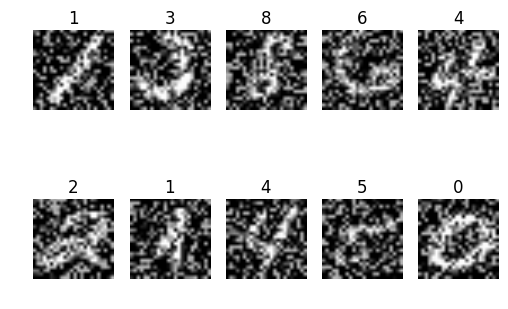

In [6]:
# -- display first ten small train examples
for i in range(10):
    plt.subplot(2,5,i+1)
    plt.imshow(Xsmall[i,:].reshape(24,24),cmap='gray')
    plt.title(repr(Ysmall[i].argmax(-1)))
    plt.axis('off')

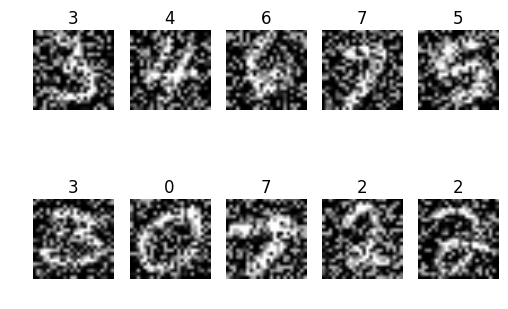

In [7]:
# -- display first ten val examples
for i in range(10):
    plt.subplot(2,5,i+1)
    plt.imshow(Xval[i,:].reshape(24,24),cmap='gray')
    plt.title(repr(Yval[i].argmax(-1)))
    plt.axis('off')

In [8]:
# -- training options; these are suggestions, feel free to experiment
trainopt = {
    'eta': 0.5,   # initial learning rate
    'maxiter': 5000,   # max number of iterations (updates) of SGD
    'display_iter': 500,  # display batch loss every display_iter update
    'batch_size': 20,
    'etadrop': 0.99, # when dropping eta, multiply it by this number (e.g., .5 means halve it)
    'eta_frac': 0.0005 # drop eta every eta_frac fraction of the max iterations
                    # so if eta_frac is .2, and maxiter is 10000, drop eta every 2000 iterations
}

NFEATURES = Xsmall.shape[1]

seed = np.random.RandomState(2341)  # to make sure everyone starts from the same point
random_init = seed.normal(scale=0.01, size=(NFEATURES,CLASSES)) # -- with random seed fixed

model = { 'weight': random_init, 'bias': np.zeros(CLASSES) }

# set the (initial?) set of lambda values to explore
lambdas = [0, *np.power(10.0, np.arange(-5, -1, 0.25))]

# we will maintain a record of models trained for different values of lambda
# these will be indexed directly by lambda value itself
small_trained_models = dict()
large_trained_models = dict()

# -- small train set: sweep the lambda values

Xsmall, Ysmall = augment_data(Xsmall, Ysmall)
for lambda_ in lambdas:
    trainopt['lambda'] = lambda_
    # -- model trained on small train set
    # note: you need deepcopy here because of the way Python handles copying of complex objects like dictionaries
    # by default, it would copy it by reference, i.e., it would make a new pointer to the same data, so later changing
    # the contents would change the "copied" version as well. deepcopy actually makes a copy.
    trained_model,valErr,trainErr = runTrainVal(Xsmall, Ysmall, copy.deepcopy(model), Xval, Yval, trainopt)
    small_trained_models[lambda_] = {'model': trained_model, "val_err": valErr, "train_err": trainErr }
    print('small train set model: -> lambda= %.4f, train error: %.2f, val error: %.2f' % (lambda_, trainErr, valErr))
del Xsmall, Ysmall

trainopt = {
    'eta': 0.5,   # initial learning rate
    'maxiter': 5000,   # max number of iterations (updates) of SGD
    'display_iter': 500,  # display batch loss every display_iter update
    'batch_size': 100,
    'etadrop': 0.99, # when dropping eta, multiply it by this number (e.g., .5 means halve it)
    'eta_frac': 0.0005 # drop eta every eta_frac fraction of the max iterations
                    # so if eta_frac is .2, and maxiter is 10000, drop eta every 2000 iterations
}

lambdas = [0, *np.power(10.0, np.arange(-5, -1, 0.25))]

for lambda_ in lambdas:
    trainopt['lambda'] = lambda_
    # -- model trained on large train set
    trained_model,valErr,trainErr = runTrainVal(Xlarge, Ylarge, copy.deepcopy(model), Xval, Yval, trainopt)
    large_trained_models[lambda_] = {'model': trained_model, "val_err": valErr, "train_err": trainErr }
    print('large train set model: -> lambda= %.4f, train error: %.2f, val error: %.2f' % (lambda_, trainErr, valErr))

best_small_trained_lambda = 0.
best_small_trained_model = None
best_small_trained_val_err = 100.
for lambda_,results in small_trained_models.items():
    if results['val_err'] < best_small_trained_val_err:
        best_small_trained_val_err = results['val_err']
        best_small_trained_model = results['model']
        best_small_trained_lambda = lambda_
        
best_large_trained_lambda = 0.
best_large_trained_model = None
best_large_trained_val_err = 100.
for lambda_,results in large_trained_models.items():
    if results['val_err'] < best_large_trained_val_err:
        best_large_trained_val_err = results['val_err']
        best_large_trained_model = results['model']
        best_large_trained_lambda = lambda_

print("Best small train model val err:", best_small_trained_val_err)
print("Best small train model lambda:", best_small_trained_lambda)
print("Best large train model val err:", best_large_trained_val_err)
print("Best large train model lambda:", best_large_trained_lambda)

size of X, Y:  400 400
size of X, Y including replicants: 41048 41048
       0 batch loss: 2.25335882, val loss: 2.30078478, error rate: 0.8760
     500 batch loss: 0.32673967, val loss: 0.82250015, error rate: 0.2820
    1000 batch loss: 0.73711051, val loss: 0.82446637, error rate: 0.2825
    1500 batch loss: 0.37136901, val loss: 0.82177475, error rate: 0.2810
    2000 batch loss: 0.29471786, val loss: 0.82125372, error rate: 0.2810
    2500 batch loss: 0.14979276, val loss: 0.82123968, error rate: 0.2810
    3000 batch loss: 0.53905858, val loss: 0.82123785, error rate: 0.2810
    3500 batch loss: 1.00428564, val loss: 0.82123786, error rate: 0.2810
    4000 batch loss: 0.20142899, val loss: 0.82123783, error rate: 0.2810
    4500 batch loss: 0.26239561, val loss: 0.82123783, error rate: 0.2810
small train set model: -> lambda= 0.0000, train error: 10.39, val error: 28.10
       0 batch loss: 2.37500551, val loss: 2.30078478, error rate: 0.8760
     500 batch loss: 0.33737045, val 

In [9]:

#Generate a Kaggle submission file using `model`
kaggleX = load_data(data_fn, 'kaggle')
kaggleYhat = predict(kaggleX, best_large_trained_model).argmax(-1)
save_submission('submission-large.csv', kaggleYhat)

# same for small training set
kaggleYhat = predict(kaggleX, best_small_trained_model).argmax(-1)
save_submission('submission-small.csv', kaggleYhat)


Saved: submission-large.csv
Saved: submission-small.csv


Best large dataset model
Confusion matrix:


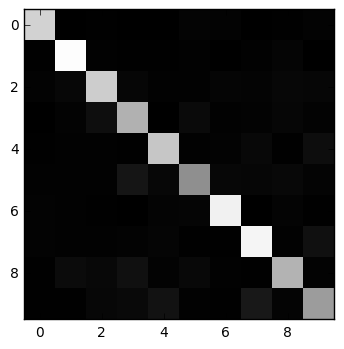

Weight visualization:


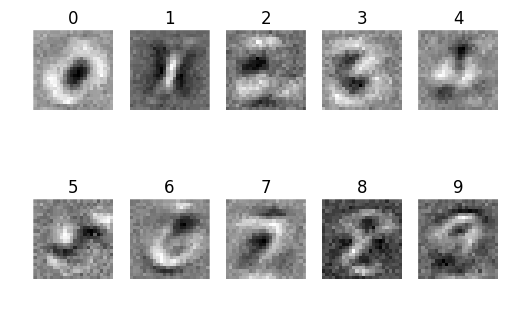

Best small dataset model
Confusion matrix:


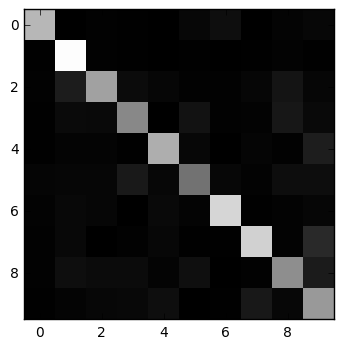

Weight visualization:


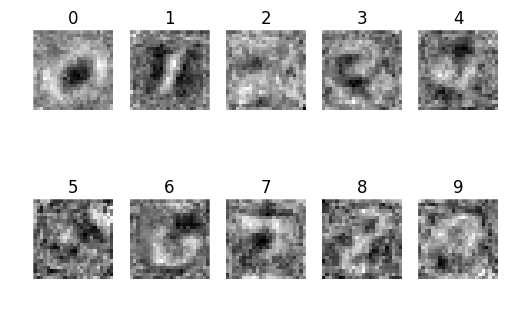

In [10]:
def prob_to_label(array):
    return array.argmax(axis=1)

def imshow(array):
    plt.imshow(array, cmap='gray', interpolation='none')

Yval = prob_to_label(Yval)    
    
for name, model in zip(["large", "small"],
                       [best_large_trained_model, best_small_trained_model]):
    W = model['weight']
    print("Best", name, "dataset model")
    
    # Confusion matrix
    
    Y = prob_to_label(predict(Xval, model))
    M = np.zeros([CLASSES] * 2, dtype=np.int)
    
    for i, y_val in enumerate(Yval):
        M[y_val, Y[i]] += 1
        
    assert (Y == Yval).sum() == M.trace()
            
    print("Confusion matrix:")
    imshow(M)
    plt.show()
    
    # Visualize weights
    
    print("Weight visualization:")
    
    for klass in range(W.shape[1]):
        plt.subplot(2,5,klass+1)
        imshow(W[:, klass].reshape(24, 24))
        plt.title(klass)
        plt.axis('off')
    plt.show()